In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from scipy.stats import pearsonr
import sklearn.preprocessing 
from sklearn.feature_selection import f_regression, SelectKBest, RFE 
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from math import sqrt 

#### From the data.wold overview of this data:

In the above reference, two datasets were created, using red and white wine samples.
The inputs include objective tests (e.g. PH values) and the output is based on sensory data
(median of at least 3 evaluations made by wine experts). Each expert graded the wine quality
between 0 (very bad) and 10 (very excellent). Several data mining methods were applied to model
these datasets under a regression approach. The support vector machine model achieved the
best results. Several metrics were computed: MAD, confusion matrix for a fixed error tolerance (T),
etc. Also, we plot the relative importances of the input variables (as measured by a sensitivity
analysis procedure).

Relevant Information:

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine.
For more details, consult: http://www.vinhoverde.pt/en/ or the reference [Cortez et al., 2009].
Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables
are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks.
The classes are ordered and not balanced (e.g. there are munch more normal wines than
excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent
or poor wines. Also, we are not sure if all input variables are relevant. So
it could be interesting to test feature selection methods.



The unit "mg/dm³" stands for "milligrams per cubic decimeter", where "milligrams" is the unit of mass and "cubic decimeter" is the unit of volume.

It is used to measure the amount of a solute dissolved in a solvent. For example, if a solution contains 10 milligrams of a substance per cubic decimeter of solution, the concentration of the substance in that solution would be expressed as 10 mg/dm³.

In [2]:
df_red = pd.read_csv('https://query.data.world/s/xvy3biopsnfrfxfgialtawp6v477mk?dws=00000')

In [3]:
df_white = pd.read_csv('https://query.data.world/s/lmm2oc73ncl233bsk4m4pergggesuf?dws=00000')

In [4]:
df_red.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

In [5]:
df_red.quality.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [6]:
df_white.quality.value_counts()

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64

In [7]:
df_white.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [8]:
df_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [9]:
df_red.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [10]:
def unique_rows(df):
    """
    Returns the input dataframe with only unique rows.
    """
    return df.drop_duplicates()

In [11]:
def get_df():
    '''
    get_df pulls red and white wine df's from data.world url's,
    creates a new column for wine color, concats them and returns 
    them as a single pandas df with only unique rows. Outliers are
    also removed in accordance with the 3-sigma rule.
    '''
    # Pull in red and white wine df's
    df_white = pd.read_csv(
        'https://query.data.world/s/lmm2oc73ncl233bsk4m4pergggesuf?dws=00000')
    df_red = pd.read_csv(
        'https://query.data.world/s/xvy3biopsnfrfxfgialtawp6v477mk?dws=00000')
    
    # add column for wine color before merging
    df_white['color']= 'white'
    df_red['color']= 'red'
    
    #concat them and return new df
    df= pd.concat([df_white, df_red], ignore_index=True)
    
    # remove duplicates and outliers
    df = unique_rows(df)
    for col in df.columns:
        if df[col].dtype in [np.int64, np.float64]:
            # calculate mean and std deviation for each column
            col_mean = df[col].mean()
            col_std = df[col].std()
            # create lower and upper bounds for the column
            lower_bound = col_mean - 3*col_std
            upper_bound = col_mean + 3*col_std
            # remove rows with values outside the bounds
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
            
    return df

In [12]:
df = get_df()

In [13]:
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
6            6.2              0.32         0.16             7.0      0.045   
9            8.1              0.22         0.43             1.5      0.044   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
6                 30.0                 136.0   0.9949  3.18       0.47   
9                 28.0                 129.0   0.9938  3.22       0.45   

   alcohol  quality  color  
1      9.5        6  white  
2     10.1        6  white  
3      9.9        6  white  
6      9.6        6  white  
9     11.0        6  white

In [14]:
def target_dist(df):
    '''
    target_dist takes in a pandas dataframe, then proceeds to plot
    the distribution of the target variable, quality rating.
    '''
    #define figure size
    plt.figure(figsize=(10, 5))
    # create histogram
    sns.histplot(x='quality', data=df, color='cyan', binwidth=0.5)
    # calculate mean
    mean_quality = df['quality'].mean()
    # add mean line
    plt.axvline(mean_quality, color='red', linestyle='--', label='Mean Quality')
    # add mean value as text label
    plt.text(mean_quality + .8, 1000, f'Mean Quality = {mean_quality:.2f}', 
             fontsize=10, color='red')
    # add labels and title
    plt.xlabel('Quality Rating')
    plt.title('Visualizing the Target Variable')
    # add legend and grid
    plt.legend()
    plt.grid(True, alpha=0.5, linestyle='--')
    # show plot
    plt.show()

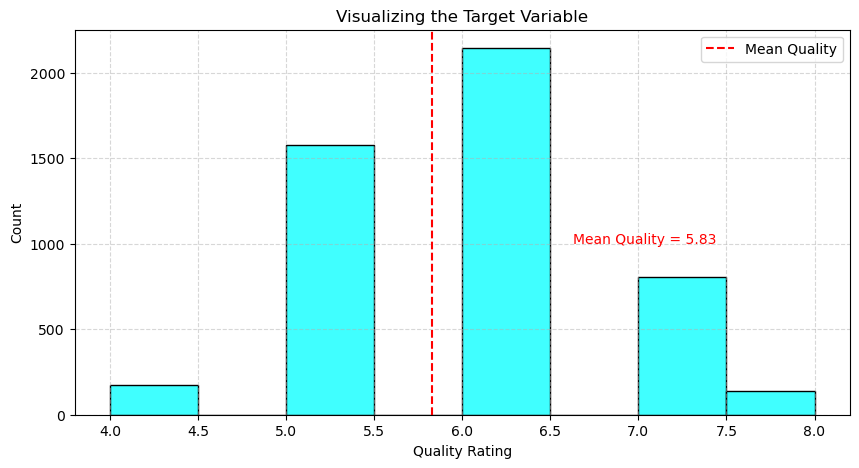

In [15]:
target_dist(df)

In [16]:
def train_val_test_split(df):
    '''
    takes in a pandas df, then splits between train, validate,
    and test subsets. 56/24/20 split
    '''
    train_validate, test=train_test_split(df, 
                                 train_size=.8, 
                                 random_state=828)
    
    train, validate =train_test_split(train_validate, 
                                      test_size=.3, 
                                      random_state=828)
    return train, validate, test

In [17]:
train, validate, test = train_val_test_split(df)

In [18]:
train.shape, validate.shape, test.shape

((2713, 13), (1163, 13), (970, 13))

Exploration Question 1:
Is the mean alcohol content in high quality wine (7 and up) significantly higher than the alcohol content of wine with lower quality ratings (6 and below) ?
- 
H0: There is not a significant difference in the average alcohol content between high quality wine (7-9) and wine with lower quality ratings (6 and below)
- 
Ha: There is a significant difference in the average alcohol content between high quality wine (7-9) and wine with lower quality ratings (6 and below)

In [19]:
def abv_plots(train):
    '''
    abv_plots takes in train data and produces a histplot comparing the mean ABV of 
    high quality wines versus lower quality wines.
    '''
    # identify low and high quality wines
    high= train[train['quality'] >= 7]
    low= train[train['quality'] <= 5]
    #define figure size
    plt.figure(figsize=(10, 5))
    # set title
    plt.title('High and Low Quality Wine ABV Compared')
    # identify low and high rated means
    mean_low_qual = low['alcohol'].mean()
    mean_high_qual = high['alcohol'].mean()
    # plot data
    sns.histplot(x='alcohol', data=low, alpha=.5, label= 'Lower Quality', color='orange')
    sns.histplot(x='alcohol', data=high, alpha=.3, label='High Quality', color='magenta')
    plt.xlabel(' % Alcohol by Volume')
    # draw low quality mean line
    plt.axvline(x=mean_low_qual, label='Lower Quality Mean ABV', color='orange')
    plt.text(mean_low_qual + 1.8, 100, f'Lower Quality Mean ABV = {mean_low_qual:.1f}%', 
             fontsize=10, color='red')
    # draw high quality mean line
    plt.axvline(x= mean_high_qual, label='High Quality Mean ABV', color='magenta')
    plt.text(mean_high_qual + .2, 120, f'High Quality Mean ABV= {mean_high_qual:.1f}%', 
             fontsize=10, color='red')
    # produce legen
    plt.legend()
    # show gridlines for easy reading
    plt.grid(True, alpha=0.75, linestyle='--')
    # show the vis
    plt.show()

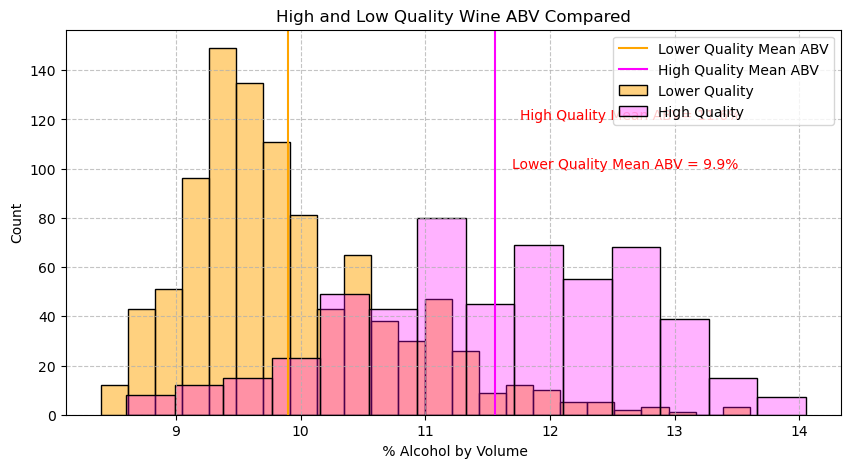

In [20]:
abv_plots(train)

In [21]:
def abv_tstat(train):
    '''
    abv_tstat takes in train data, the performs a two-sample t-test 
    comparing high quality and lower quality wines based on ABV.
    '''
    # create two samples
    high_quality = train[train['quality']>= 7]['alcohol']
    low_quality = train[train['quality'] <= 5]['alcohol']

    # perform two-sample t-test
    t_statistic, p_value = stats.ttest_ind(high_quality, low_quality, equal_var=True)

    # print results
    print(f"t-statistic: {t_statistic:.2f}")
    print(f"p-value: {p_value:.4f}")


In [22]:
abv_tstat(train)

t-statistic: 32.53
p-value: 0.0000


Exploration Question 2:
Does high quality wine (7+) have lower chloride levels than lower quality wine(6 and below)?
- 
H0: There is no difference in the average chloride levels in wines of high quality and wines of lower quality
- 
Ha: The average chloride levels in wines of high quality are significantly lower than wines of lower quality

In [23]:
def chlor_plots(train):
    '''
    chlor_plots takes in train data and visualizes chloride levels
    between high wuality wines(7+) and lower quality wines(6 and below)
    '''
    # identify low and high quality wines
    high= train[train['quality'] >= 7]
    low= train[train['quality'] <= 5]
    # identify low and high rated means
    mean_low_chlor = low['chlorides'].mean()
    mean_high_chlor = high['chlorides'].mean()
    # set figure size
    plt.figure(figsize=(10,5))
    # set title
    plt.title('Chloride Levels Compared')
    # plot data
    sns.histplot(x='chlorides', data=high, alpha=1, color = 'cyan', label='High Quality Wines')
    sns.histplot(x='chlorides', data=low, alpha=.4, color = 'magenta', label='Lower Quality Wines')
    # x axis label
    plt.xlabel('Chloride Levels (g / dm^3)')
    # draw mean lines and text
    plt.axvline(x=mean_high_chlor, color='cyan', label='High Quality Mean Chloride')
    plt.text(mean_high_chlor + .058, 125, f'High Quality Mean Chloride= {mean_high_chlor:.2f}%', 
             fontsize=10, color='red')
    # draw mean lines and text
    plt.axvline(x=mean_low_chlor, color='magenta', label='Lower Quality Mean Chloride')
    plt.text(mean_low_chlor + .035, 100, f'Lower Quality Mean Chloride = {mean_low_chlor:.2f}%', 
             fontsize=10, color='red')
    # add legend
    plt.legend()
    # add gridlines
    plt.grid(True, alpha=0.5, linestyle='--')
    # set the x-axis limits to 0 and 0.1
    plt.xlim(0,0.16)  
    plt.show()

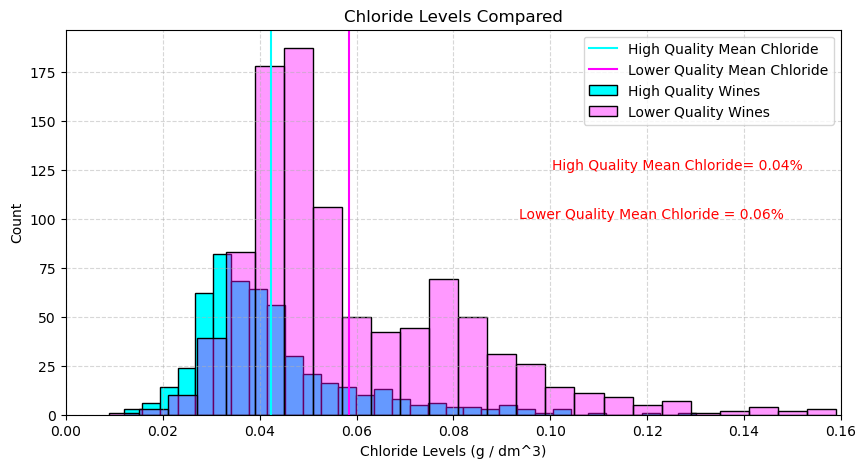

In [24]:
chlor_plots(train)

In [25]:
def chlor_stat(train):
    '''
    chlor_stat takes in train data, the performs a two-sample t-test 
    comparing high quality and lower quality wines based on chloride level.
    '''
    # create two samples
    high_quality = train[train['quality']>= 7]['chlorides']
    low_quality = train[train['quality'] <= 5]['chlorides']

    # perform two-sample t-test
    t_statistic, p_value = stats.ttest_ind(low_quality, high_quality, equal_var=True)

    # print results
    print(f"t-statistic: {t_statistic:.2f}")
    print(f"p-value: {p_value:.4f}")

In [26]:
chlor_stat(train)

t-statistic: 14.26
p-value: 0.0000


Exploration Question 3:
Does high quality wine (7+) have lower residual sugar levels than lower quality wine(5 and below)?
- 
H0: There is no difference in the average residual sugar levels in wines of high quality and wines of lower quality
- 
Ha: The average residual sugar levels in wines of higher quality wines are significantly lower than wines of lower quality

In [27]:
def sugar_plots(train):
    '''
    chlor_plots takes in train data and visualizes residual sugar levels
    between high quality wines(7+) and lower quality wines(6 and below)
    '''
    # identify low and high quality wines
    high= train[train['quality'] >= 7]
    low= train[train['quality'] <= 5]
    # identify low and high rated means
    mean_low_sugar = low['residual sugar'].mean()
    mean_high_sugar = high['residual sugar'].mean()
    # set figure size
    plt.figure(figsize=(10,5))
    # set title
    plt.title('Residual Sugar Levels Compared')
    # plot data
    sns.histplot(x='residual sugar', data=high, alpha=.8, color = 'cyan', label='High Quality Wines')
    sns.histplot(x='residual sugar', data=low, alpha=.4, color = 'magenta', label='Lower Quality Wines')
    # x axis label
    plt.xlabel('Residual Sugar Levels (g / dm^3)')
    # draw mean lines and text
    plt.axvline(x=mean_high_sugar, color='cyan', label='High Quality Mean Residual Sugar')
    plt.text(mean_high_sugar + 7, 220, f'High Quality Mean Residual Sugar= {mean_high_sugar:.2f}%', 
             fontsize=10, color='red')
    # draw mean lines and text
    plt.axvline(x=mean_low_sugar, color='magenta', label='Lower Quality Mean Residual Sugar')
    plt.text(mean_low_sugar + 6, 180, f'Lower Quality Mean Residual Sugar = {mean_low_sugar:.2f}%', 
             fontsize=10, color='red')
    # add legend
    plt.legend()
    # add gridlines
    plt.grid(True, alpha=0.5, linestyle='--')
    # set the x-axis limits to 0 and 0.1
    plt.xlim(0, 20)  
    plt.show()

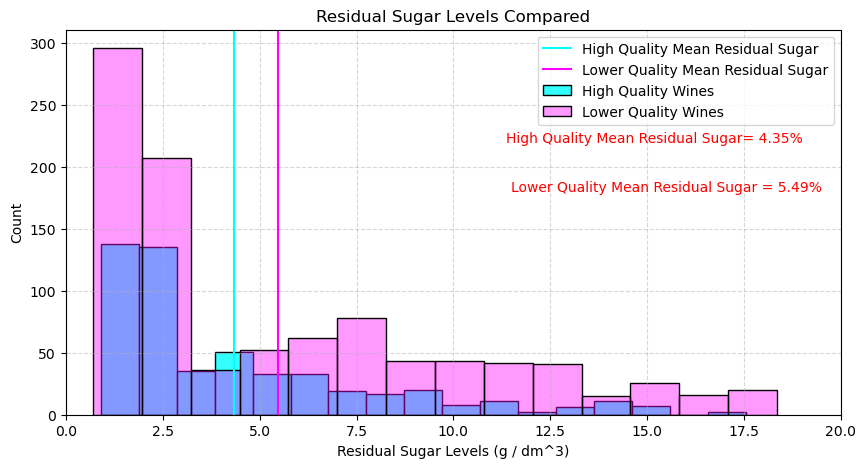

In [28]:
sugar_plots(train)

In [29]:
def sugar_stat(train):
    '''
    sugar_stat takes in train data, the performs a two-sample t-test 
    comparing high quality and lower quality wines based on residual sugar level.
    '''
    # create two samples
    high_quality = train[train['quality']>= 7]['residual sugar']
    low_quality = train[train['quality'] <= 5]['residual sugar']

    # perform two-sample t-test
    t_statistic, p_value = stats.ttest_ind(low_quality, high_quality, equal_var=True)

    # print results
    print(f"t-statistic: {t_statistic:.2f}")
    print(f"p-value: {p_value:.4f}")

In [30]:
sugar_stat(train)

t-statistic: 4.94
p-value: 0.0000


Exploration Question 4:
Does high quality wine (7+) have lower Volatile Acidity levels than lower quality wine(5 and below)?
- 
H0: There is no difference in the average Volatile Acidity levels in wines of high quality and wines of lower quality
- 
Ha: The average Volatile Acidity levels in wines of higher quality wines are significantly lower than wines of lower quality

In [31]:
def vol_acid_plots(train):
    '''
    chlor_plots takes in train data and visualizes volatile acidity levels
    between high quality wines(7+) and lower quality wines(6 and below)
    '''
    # identify low and high quality wines
    high= train[train['quality'] >= 7]
    low= train[train['quality'] <= 5]
    # identify low and high rated means
    mean_low_vol = low['volatile acidity'].mean()
    mean_high_vol = high['volatile acidity'].mean()
    # set figure size
    plt.figure(figsize=(10,5))
    # set title
    plt.title('Volatile Acidity Levels Compared')
    # plot data
    sns.histplot(x='volatile acidity', data=high, alpha=.8, color = 'cyan', label='High Quality Wines')
    sns.histplot(x='volatile acidity', data=low, alpha=.4, color = 'magenta', label='Lower Quality Wines')
    # x axis label
    plt.xlabel('Volatile Acidity Levels (g / dm^3)')
    # draw mean lines and text
    plt.axvline(x=mean_high_vol, color='cyan', label='High Quality Mean Volatile Acidity')
    plt.text(mean_high_vol + .3, 125, f'High Quality Mean Volatile Acidity= {mean_high_vol:.2f}%', 
             fontsize=10, color='red')
    # draw mean lines and text
    plt.axvline(x=mean_low_vol, color='magenta', label='Lower Quality Mean Volatile Acidity')
    plt.text(mean_low_vol + .18, 110, f'Lower Quality Mean Volatile Acidity = {mean_low_vol:.2f}%', 
             fontsize=10, color='red')
    # add legend
    plt.legend()
    # add gridlines
    plt.grid(True, alpha=0.5, linestyle='--')
    # set the x-axis limits to 0 and 0.1
    plt.xlim(0, 1.2)  
    plt.show()

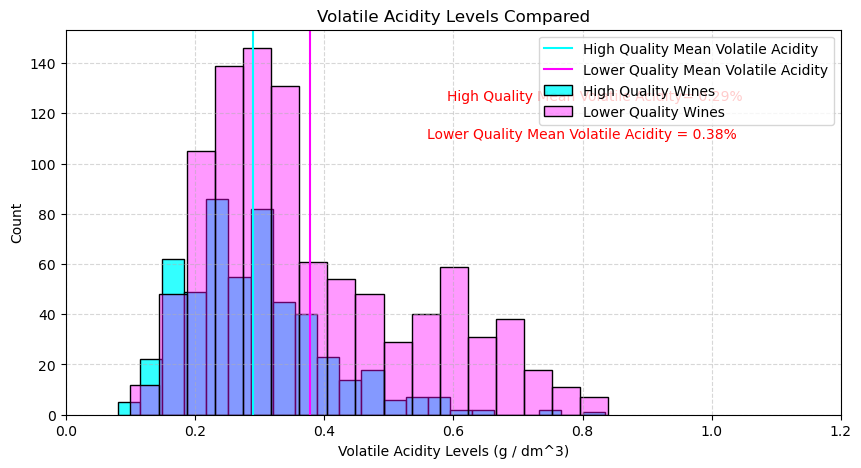

In [32]:
vol_acid_plots(train)

In [33]:
def vol_stat(train):
    '''
    vol_stat takes in train data, the performs a two-sample t-test 
    comparing high quality and lower quality wines based on volatile acidity.
    '''
    # create two samples
    high_quality = train[train['quality']>= 7]['volatile acidity']
    low_quality = train[train['quality'] <= 5]['volatile acidity']

    # perform two-sample t-test
    t_statistic, p_value = stats.ttest_ind(low_quality, high_quality, equal_var=True)

    # print results
    print(f"t-statistic: {t_statistic:.2f}")
    print(f"p-value: {p_value:.4f}")

In [34]:
vol_stat(train)

t-statistic: 11.17
p-value: 0.0000


In [35]:
def scale_wine(df):
    #identify scaler
    scaler=sklearn.preprocessing.MinMaxScaler()
    #identify cols to scale
    col=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides',
          'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
    #fit cols 
    scaler.fit(df[col])
    df[col]=scaler.transform(df[col])
    return df

In [36]:
df = scale_wine(df)

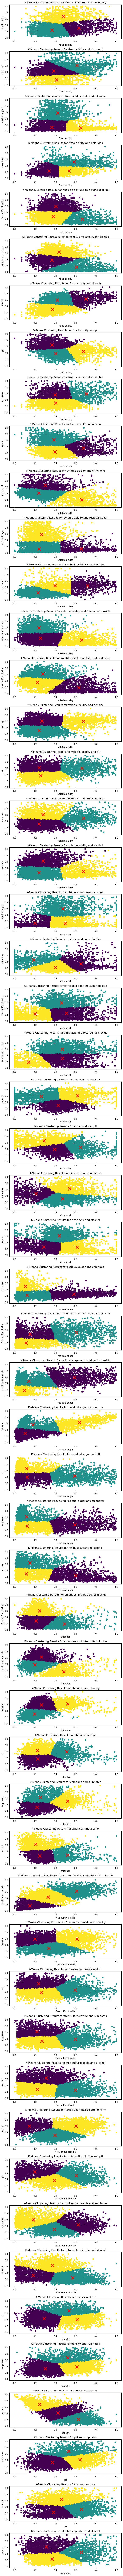

In [37]:
# Load the wine dataset
wine_df = df.copy()

# Define the columns to cluster
columns_to_cluster = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
                      'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
                      'pH', 'sulphates', 'alcohol']

# Choose the number of clusters (k=3)
k = 3

# Create all pairs of feature combinations
feature_combinations = [(col1, col2) for i, col1 in enumerate(columns_to_cluster)
                        for col2 in columns_to_cluster[i+1:]]

# Create a subplots grid
fig, axs = plt.subplots(nrows=len(feature_combinations), ncols=1, figsize=(8, len(feature_combinations)*3))

# Loop over the feature combinations and create clustering visualizations
for i, (col1, col2) in enumerate(feature_combinations):
    # Drop the target variable 'type'
    X = wine_df.drop(['color'], axis=1)
    X_cols = X[[col1, col2]].values

    # Train the K-Means model
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_cols)

    # Obtain cluster labels and centroids
    labels = kmeans.predict(X_cols)
    centroids = kmeans.cluster_centers_

    # Add cluster labels to the wine dataset
    wine_df[f'cluster{col1}_{col2}'] = labels

    # Visualize the results
    axs[i].scatter(X_cols[:, 0], X_cols[:, 1], c=labels, cmap='viridis')
    axs[i].scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, linewidths=3, color='r')
    axs[i].set_xlabel(col1)
    axs[i].set_ylabel(col2)
    axs[i].set_title(f'K-Means Clustering Results for {col1} and {col2}')

plt.tight_layout()
plt.show()

In [38]:


# Generate random data
X = np.random.rand(100, 2)

# Fit KMeans model for different number of clusters
for n_clusters in range(2, 6):
    kmeans = KMeans(n_clusters=n_clusters).fit(X)
    labels = kmeans.labels_
    score = silhouette_score(X, labels)
    print("Silhouette score for {} clusters: {:.2f}".format(n_clusters, score))


Silhouette score for 2 clusters: 0.36
Silhouette score for 3 clusters: 0.38
Silhouette score for 4 clusters: 0.39
Silhouette score for 5 clusters: 0.36


In [39]:

# Generate random data
X = np.random.rand(100, 2)

# Fit KMeans model for different number of clusters
for n_clusters in range(2, 6):
    kmeans = KMeans(n_clusters=n_clusters).fit(X)
    labels = kmeans.labels_
    score = davies_bouldin_score(X, labels)
    print("Davies-Bouldin index for {} clusters: {:.2f}".format(n_clusters, score))

Davies-Bouldin index for 2 clusters: 1.08
Davies-Bouldin index for 3 clusters: 0.85
Davies-Bouldin index for 4 clusters: 0.77
Davies-Bouldin index for 5 clusters: 0.83


In [40]:
def mod_prep(train, validate, test):
    '''
    mod_prep produces x_train, y_train, x_val, y_val, x_test, y_test
    to prepare for modeling
    '''
    # drop target and identify x, y train
    x_train= train.drop(columns=['quality'])
    y_train= train['quality']
    # drop target and identify x, y validate
    x_val= validate.drop(columns=['quality'])
    y_val= validate['quality']
    # drop target and identify x, y test
    x_test= test.drop(columns=['quality'])
    y_test= test['quality']
    
    return x_train, y_train, x_val, y_val, x_test, y_test

In [41]:
train.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
4857            7.5              0.38         0.33             9.2      0.043   
5671            7.9              0.40         0.29             1.8      0.157   
3700            7.0              0.30         0.27             1.5      0.076   
6114            7.9              0.57         0.31             2.0      0.079   
1407            7.1              0.19         0.28             3.6      0.033   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
4857                 19.0                 116.0  0.99444  3.08       0.42   
5671                  1.0                  44.0  0.99730  3.30       0.92   
3700                 24.0                 145.0  0.99344  3.10       0.52   
6114                 10.0                  79.0  0.99677  3.29       0.69   
1407                 16.0                  78.0  0.99300  2.91       0.78   

      alcohol  quality  color  
4857     11.4        6  white  
5671      9.5        6    red  
3700     10.1        5  white  
6114      9.5        6    red  
1407     11.4        6  white

In [42]:
def clustering(train, f1, f2):
    '''
    clustering fits and predicts Kmeans clustering to the input featues of the
    dataset
    '''
    # set random seed
    seed = 828
    # define 'X'
    X = train[[f1, f2]]
    # fit the thing
    kmeans = KMeans(n_clusters = 3, random_state= seed)
    kmeans.fit(X)
    kmeans.predict(X)
    # scale features
    mm_scaler = sklearn.preprocessing.MinMaxScaler()
    X[[f1, f2]] = mm_scaler.fit_transform(X[[f1, f2]])
    # predict
    kmeans_scale = KMeans(n_clusters = 3, random_state = 828)
    kmeans_scale.fit(X[[f1, f2]])
    kmeans_scale.predict(X[[f1, f2]])
    # add predictions to a new column
    X['scaled_clusters'] = kmeans_scale.predict(X[[f1, f2]])
    
    return X    
   

In [71]:
def best_cluster(train, f1, f2):
    '''
    best_cluster takes in the data set, and the two feautures to cluster,
    then makes a graph to show the most optimal cluster number.
    '''
    # define 'X'
    X = clustering(df, f1, f2)
    # empty list
    inertia = []
    seed = 828 
    # for loop to test different number of clusters
    for n in range(1,11):

        kmeans = KMeans(n_clusters = n, random_state = seed)

        kmeans.fit(X[[f1, f2]])

        inertia.append(kmeans.inertia_)
        
    # append reults to new df    
    results_df = pd.DataFrame({'n_clusters': list(range(1,11)),
                               'inertia': inertia})   
    # plot the reults
    sns.set_style("whitegrid")
    sns.relplot(data = results_df, x='n_clusters', y = 'inertia', kind = 'line')
    plt.xticks(np.arange(0, 11, step=1))
    point = (3, 110) # specify the x and y values of the point to annotate
    plt.annotate("optimal cluster", xy=point, xytext=(3.2, 140), 
                 arrowprops=dict(facecolor='black', shrink=0.05))
    # title
    plt.title('Clusters Versus Inertia')
    
    return plt.show()

/var/folders/8k/klwd85kj0d3_n66z9ht0xg7r0000gn/T/ipykernel_79466/465020416.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[[f1, f2]] = mm_scaler.fit_transform(X[[f1, f2]])
/var/folders/8k/klwd85kj0d3_n66z9ht0xg7r0000gn/T/ipykernel_79466/465020416.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['scaled_clusters'] = kmeans_scale.predict(X[[f1, f2]])


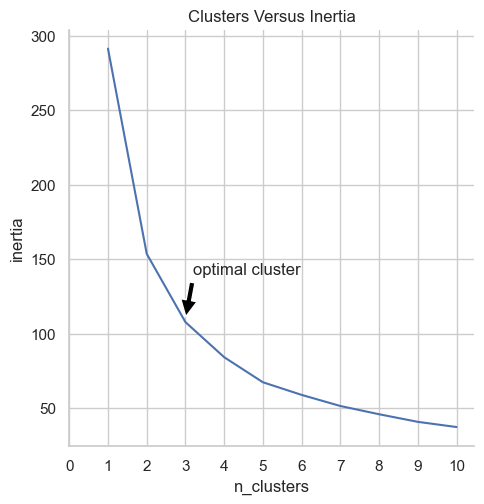

In [72]:
best_cluster(train, 'fixed acidity', 'volatile acidity')

In [45]:
def cluster_relplot(df, f1, f2):
    '''
    this functions creates a relplot of the clusters
    '''
    
    sns.set(style = "whitegrid")
    
    X = clustering(df, f1, f2)
    
    sns.relplot(data = X, x = f1, y = f2, hue = 'scaled_clusters')
    
    plt.title('Clusters')
    
    return plt.show() 

/var/folders/8k/klwd85kj0d3_n66z9ht0xg7r0000gn/T/ipykernel_79466/465020416.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[[f1, f2]] = mm_scaler.fit_transform(X[[f1, f2]])
/var/folders/8k/klwd85kj0d3_n66z9ht0xg7r0000gn/T/ipykernel_79466/465020416.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['scaled_clusters'] = kmeans_scale.predict(X[[f1, f2]])


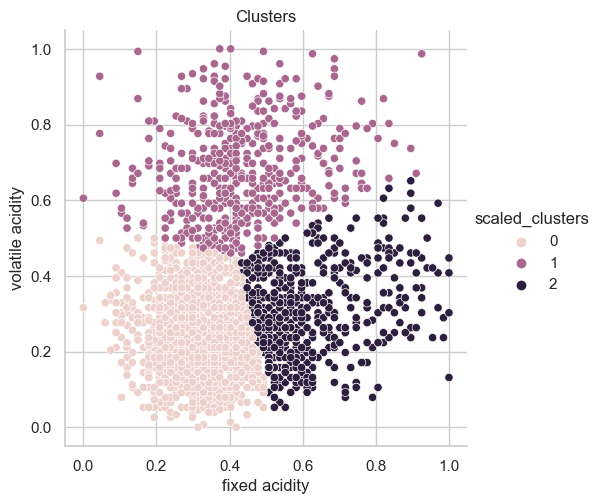

In [46]:
cluster_relplot(train, 'fixed acidity', 'volatile acidity')

In [47]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def find_best_features(df, k_min, k_max):
    '''
    This function takes in a dataframe,  a minimum number 
    of clusters (k_min), and a maximum number 
    of clusters (k_max). It returns a list of the best features 
    to use for clustering based on the Silhouette score.
    '''
    # Remove the target column from the dataframe
    X = df.drop(['quality', 'color'], axis=1)
    
    # Create an empty list to store the best features
    best_features = []
    
    # Loop through the range of k values
    for k in range(k_min, k_max+1):
        # Fit a KMeans clustering model
        kmeans = KMeans(n_clusters=k, random_state=828).fit(X)
        
        # Calculate the Silhouette score for the clustering
        score = silhouette_score(X, kmeans.labels_)
        
        # If this is the first iteration, add all features to the best_features list
        if k == k_min:
            best_features = list(X.columns)
        else:
            # For each subsequent iteration, compare the Silhouette score to the previous iteration
            # If the score has improved, update the best_features list with the current set of features
            if score > prev_score:
                best_features = list(X.columns)
        
        # Set the previous score to the current score for the next iteration
        prev_score = score
    
    # Return the list of best features
    return best_features


In [48]:
find_best_features(df, 2, 10)

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

In [49]:
def combined_df(df, f1, f2):
    '''
    This function calls another function in explore.py 
    and merges a column to the original dataset
    '''
    
    X = clustering(df, f1, f2)
    
    scaled_clusters = X['scaled_clusters']
    df = pd.merge(df, scaled_clusters, left_index=True, right_index=True)
    
    return df

In [50]:
df_clusters = combined_df(df, 'fixed acidity', 'volatile acidity')

/var/folders/8k/klwd85kj0d3_n66z9ht0xg7r0000gn/T/ipykernel_79466/465020416.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[[f1, f2]] = mm_scaler.fit_transform(X[[f1, f2]])
/var/folders/8k/klwd85kj0d3_n66z9ht0xg7r0000gn/T/ipykernel_79466/465020416.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['scaled_clusters'] = kmeans_scale.predict(X[[f1, f2]])


In [51]:
df_clusters.scaled_clusters.value_counts()

1    2966
0    1021
2     859
Name: scaled_clusters, dtype: int64

In [52]:
train, validate, test = train_val_test_split(df_clusters)

In [53]:
def scale_data(train, validate, test, return_scaler=False):
    '''
    Scales the 3 data splits. 
    Takes in train, validate, and test data splits and returns their scaled counterparts.
    If return_scalar is True, the scaler object will be returned as well
    '''
    columns_scale = train.iloc[:, :11]
    columns_to_scale = columns_scale.columns
    
    # make copies of our original data so we dont gronk up anything
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    #     make the thing
    mms = sklearn.preprocessing.MinMaxScaler()
    #     fit the thing
    mms.fit(train[columns_to_scale])
    # applying the scaler:
    train_scaled[columns_to_scale] = pd.DataFrame(mms.transform(train[columns_to_scale]),
                                                  columns=train[columns_to_scale].columns.values).set_index([train.index.values])
                                                  
    validate_scaled[columns_to_scale] = pd.DataFrame(mms.transform(validate[columns_to_scale]), 
                                                     columns=validate[columns_to_scale].columns.values).set_index([validate.index.values])
    
    test_scaled[columns_to_scale] = pd.DataFrame(mms.transform(test[columns_to_scale]),
                                                 columns=test[columns_to_scale].columns.values).set_index([test.index.values])
    
    if return_scaler:
        return scaler, train_scaled, validate_scaled, test_scaled
    else:
        return train_scaled, validate_scaled, test_scaled

In [54]:
train_scaled, validate_scaled, test_scaled = scale_data(train, validate, test, return_scaler=False)

In [55]:
def splitting_subsets(train, train_scaled, validate_scaled, test_scaled):
    '''
    This function splits our train, validate, and test scaled datasets into X/y train,
    validate, and test subsets
    '''
    
    
    X_train = train_scaled.drop(columns = ['quality'])
    X_train = pd.get_dummies(X_train, columns = ['color', 'scaled_clusters'])
    y_train = train_scaled['quality']


    X_validate = validate_scaled.drop(columns = ['quality'])
    X_validate = pd.get_dummies(X_validate, columns = ['color', 'scaled_clusters'])
    y_validate = validate_scaled['quality']


    X_test = test_scaled.drop(columns = ['quality'])
    X_test = pd.get_dummies(X_test, columns = ['color', 'scaled_clusters'])
    y_test = test_scaled['quality']

    return X_train, y_train, X_validate, y_validate, X_test, y_test

In [56]:
X_train, y_train, X_validate, y_validate, X_test, y_test = splitting_subsets(train, train_scaled, validate_scaled, test_scaled)

In [57]:
X_train.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
4857       0.462687          0.394737     0.445946        0.480226   0.225166   
5671       0.522388          0.421053     0.391892        0.062147   0.980132   
3700       0.388060          0.289474     0.364865        0.045198   0.443709   
6114       0.522388          0.644737     0.418919        0.073446   0.463576   
1407       0.402985          0.144737     0.378378        0.163842   0.158940   

      free sulfur dioxide  total sulfur dioxide   density        pH  \
4857             0.219512              0.402214  0.469441  0.333333   
5671             0.000000              0.136531  0.655397  0.569892   
3700             0.280488              0.509225  0.404421  0.354839   
6114             0.109756              0.265683  0.620936  0.559140   
1407             0.182927              0.261993  0.375813  0.150538   

      sulphates   alcohol  color_red  color_white  scaled_clusters_0  \
4857   0.246377  0.530973          0            1                  1   
5671   0.971014  0.194690          1            0                  1   
3700   0.391304  0.300885          0            1                  0   
6114   0.637681  0.194690          1            0                  0   
1407   0.768116  0.530973          0            1                  0   

      scaled_clusters_1  scaled_clusters_2  
4857                  0                  0  
5671                  0                  0  
3700                  1                  0  
6114                  0                  1  
1407                  1                  0

In [58]:
def get_baseline(y_train):
    '''
    This function takes in y_train, then calculates the baseline RMSE
    '''
    
    preds_df = pd.DataFrame({'actual': y_train})
    
    preds_df['baseline'] = y_train.mean()
    
    baseline_rmse = sqrt(mean_squared_error(preds_df.actual, preds_df.baseline))

    return baseline_rmse

In [59]:
get_baseline(y_train)

0.8508193687671466

In [60]:
def linear_model(X_train, y_train):
    '''
    This function makes a linear regression model, fits, and predicts the output values.
    Giving us a dataframe of predicted linear and actual values
    '''
    
    lm = LinearRegression()

    lm.fit(X_train, y_train)
    
    lm_preds = lm.predict(X_train)
    
    preds_df = pd.DataFrame({'actual': y_train,'lm_preds': lm_preds})
    
    lm_rmse = sqrt(mean_squared_error(preds_df['lm_preds'], preds_df['actual']))
    
    df = pd.DataFrame({'model': 'linear', 'linear_rmse': lm_rmse},index=['0']) 
                      
    return df


def lasso_lars(X_train, y_train):
    
    '''
        This function is used to run a for loop on lasso lars. We will use the best preforming model,
        and use it on the validate datasets.
    '''
    
    metrics = []

    for i in np.arange(0.05, 1, .05):
    
        lasso = LassoLars(alpha = i )
    
        lasso.fit(X_train, y_train)
    
        lasso_preds = lasso.predict(X_train)
        
        preds_df = pd.DataFrame({'actual': y_train})
    
        preds_df['lasso_preds'] = lasso_preds

        lasso_rmse = sqrt(mean_squared_error(preds_df['actual'], preds_df['lasso_preds']))
    
        output = {
                'alpha': i,
                'lasso_rmse': lasso_rmse
                 }
    
        metrics.append(output)

    df = pd.DataFrame(metrics)    
    return df.sort_values('lasso_rmse')


def tweedie_models(X_train, y_train):
    
    '''
    This function is used to run a for loop on tweedie model. We will use the best preforming model,
    and use it on the validate datasets.
    '''
    
    metrics = []

    for i in range(0, 4, 1):
    
        tweedie = TweedieRegressor(power = i)
    
        tweedie.fit(X_train, y_train)
    
        tweedie_preds = tweedie.predict(X_train)
        
        preds_df = pd.DataFrame({'actual': y_train})
    
        preds_df['tweedie_preds'] = tweedie_preds
    
        tweedie_rmse = sqrt(mean_squared_error(preds_df.actual, preds_df.tweedie_preds))
    
        output = {
                'power': i,
                'tweedie_rmse': tweedie_rmse
                 }
    
        metrics.append(output)

    df = pd.DataFrame(metrics)    
    return df.sort_values('tweedie_rmse') 


def linear_poly(X_train, y_train):
    
    '''
        This function is used to run a for loop on liner poly. We will use the best preforming model,
        and use it on the validate datasets.
    '''
    
    metrics = []

    for i in range(2,4):

        pf = PolynomialFeatures(degree = i)

        pf.fit(X_train, y_train)

        X_polynomial = pf.transform(X_train)

        lm2 = LinearRegression()

        lm2.fit(X_polynomial, y_train)
        
        preds_df = pd.DataFrame({'actual': y_train})

        preds_df['poly_preds'] = lm2.predict(X_polynomial)

        poly_rmse = sqrt(mean_squared_error(preds_df['actual'], preds_df['poly_preds']))

        output = {
                'degree': i,
                'poly_rmse': poly_rmse
                 }

        metrics.append(output)

    df = pd.DataFrame(metrics)    
    return df.sort_values('poly_rmse') 


def validate_models(X_train, y_train, X_validate, y_validate):
    '''
    This model is used to test our models on the validate datasets and then return the results. 
    These results will then be used to find our best model.
    '''
       
    lm = LinearRegression()

    lm.fit(X_train, y_train)
    
    lm_val = lm.predict(X_validate)
    
    val_preds_df = pd.DataFrame({'actual_val': y_validate})
    
    val_preds_df['lm_preds'] = lm_val

    lm_rmse_val = sqrt(mean_squared_error(val_preds_df['actual_val'], val_preds_df['lm_preds']))

    #tweedie model
    
    tweedie = TweedieRegressor(power = 1)
    
    tweedie.fit(X_train, y_train)
    
    tweedie_val = tweedie.predict(X_validate)
    
    val_preds_df['tweedie_preds'] = tweedie_val
    
    tweedie_rmse_val = sqrt(mean_squared_error(val_preds_df.actual_val, val_preds_df.tweedie_preds))
    
    #polynomial model
    
    pf = PolynomialFeatures(degree = 2)
    
    pf.fit(X_train, y_train)
    
    X_train = pf.transform(X_train)
    X_validate = pf.transform(X_validate)
    
    lm2 = LinearRegression()
    
    lm2.fit(X_train, y_train)
    
    val_preds_df['poly_vals'] = lm2.predict(X_validate)
    
    poly_validate_rmse = sqrt(mean_squared_error(val_preds_df.actual_val, val_preds_df['poly_vals']))

    #lasso_lars model
    
    lasso = LassoLars(alpha = .05 )
    
    lasso.fit(X_train, y_train)
    
    lasso_val = lasso.predict(X_validate)
    
    val_preds_df['lasso_preds'] = lasso_val

    lasso_rmse_val = sqrt(mean_squared_error(val_preds_df.actual_val, val_preds_df['lasso_preds']))
    
    
    return lm_rmse_val, tweedie_rmse_val, lasso_rmse_val, poly_validate_rmse

In [61]:
def best_models(X_train, y_train, X_validate, y_validate):
    
    '''
    This function uses the train and validate datasets and returns the results of the best preforming model 
    for each algorithm. The results are returned as a dataframe.
    '''
    
    lm_rmse = linear_model(X_train, y_train).iloc[0,1]
    
    lasso_rmse = lasso_lars(X_train, y_train).iloc[0,1]
    
    tweedie_rmse = tweedie_models(X_train, y_train).iloc[0,1]
        
    poly_rmse = linear_poly(X_train, y_train).iloc[1,1]
    
    baseline_rmse = get_baseline(y_train)
    
    lm_rmse_val, tweedie_rmse_val, lasso_rmse_val, poly_validate_rmse = validate_models(X_train, y_train, X_validate, y_validate)
    
    df = pd.DataFrame({'model': ['linear', 'tweedie', 'lasso_lars','linear_poly', 'baseline'],
                      'train_rmse': [lm_rmse, tweedie_rmse, lasso_rmse, poly_rmse,  baseline_rmse],
                      'validate_rmse': [lm_rmse_val, tweedie_rmse_val, lasso_rmse_val, poly_validate_rmse, baseline_rmse]})
    
    df['difference'] = df['train_rmse'] - df['validate_rmse']
    
    return df.sort_values('difference').reset_index().drop(columns = ('index'))

In [62]:
best_models(X_train, y_train, X_validate, y_validate)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardS

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


model  train_rmse  validate_rmse  difference
0  linear_poly    0.672710       0.687548   -0.014838
1   lasso_lars    0.850819       0.858614   -0.007794
2      tweedie    0.787761       0.789717   -0.001956
3     baseline    0.850819       0.850819    0.000000
4       linear    0.703504       0.703410    0.000095

In [73]:
def test_model(X_train, y_train, X_test, y_test):
    '''
    This function is used to test our best model and use it 
    on the test datasets to get our final results.
    '''
    
    # Step 1: Create a PolynomialFeatures object with degree=2
    pf = PolynomialFeatures(degree=2)
    
    # Step 2: Fit the PolynomialFeatures object to the training data
    pf.fit(X_train)
    
    # Step 3: Transform the training and test data using the fitted PolynomialFeatures object
    X_train_poly = pf.transform(X_train)
    X_test_poly = pf.transform(X_test)
    
    # Step 4: Create a LinearRegression object and fit it to the transformed training data
    lm2 = LinearRegression()
    lm2.fit(X_train_poly, y_train)
    
    # Step 5: Use the fitted LinearRegression object to predict the target variable for the test data
    lm2_preds = lm2.predict(X_test_poly)
    
    # Step 6: Create a dataframe to store the actual test values and the predicted values
    test_preds_df = pd.DataFrame({'actual_test': y_test})
    test_preds_df['poly_test'] = lm2_preds
    
    # Step 7: Calculate the root mean squared error (RMSE) between the actual and predicted test values
    poly_test_rmse = sqrt(mean_squared_error(test_preds_df.actual_test, test_preds_df['poly_test']))
    
    # Step 8: Return the RMSE value
    print(f' The RMSE score on test data is: {poly_test_rmse}')

    

In [74]:
test_model(X_train, y_train, X_test, y_test)

 The RMSE score on test data is: 0.6837608969872596
